<a href="https://colab.research.google.com/github/trevinofernando/CannyEdgeDetection/blob/main/CannyEdgeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from math import sqrt
from math import exp
from math import pi
import numpy as np 
import requests
import cv2

Gaussian filer 3x3:


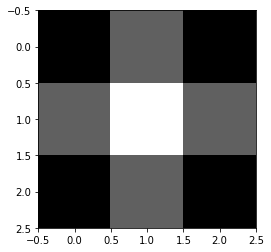

Gaussian filer 5x5:


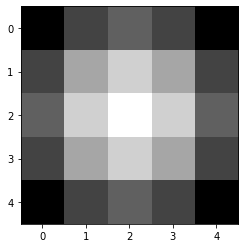

Gaussian filer 15x15:


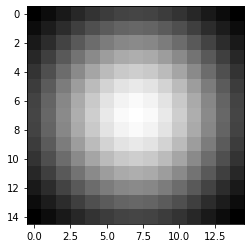

In [2]:
# making a one dimensional gaussian filter according to the given sigma
def OneDimensionalGaussian(k=3,sigma=1):
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in range(-int(k/2),int(k/2)+1)]

#The following are some example visuals of the 1D filter multiplied 
# with itself to create a 2D filter. Different sizes are shown.
print("Gaussian filer 3x3:")
temp_Gx_3x3 = np.array(OneDimensionalGaussian(3,1))
temp_G = temp_Gx_3x3 * temp_Gx_3x3.reshape(-1,1)
plt.figure()
plt.imshow(temp_G, cmap='gray')
plt.show()

print("Gaussian filer 5x5:")
temp_Gx_5x5 = np.array(OneDimensionalGaussian(5,2))
temp_G = temp_Gx_5x5 * temp_Gx_5x5.reshape(-1,1)
plt.imshow(temp_G, cmap='gray')
plt.show()

print("Gaussian filer 15x15:")
temp_Gx_15x15 = np.array(OneDimensionalGaussian(15,5))
temp_G = temp_Gx_15x15 * temp_Gx_15x15.reshape(-1,1)
plt.imshow(temp_G, cmap='gray')
plt.show()

Gaussian filer 3x3:
[ 0.24197072  0.         -0.24197072]


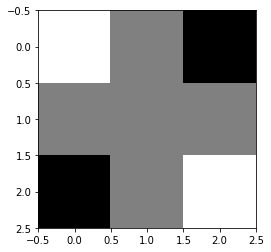

Gaussian filer 5x5:
[ 0.06049268  0.04400817  0.         -0.04400817 -0.06049268]


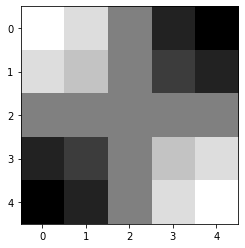

Gaussian filer 15x15:
[ 0.00838474  0.00932093  0.00967883  0.00927013  0.00799739  0.00589232
  0.00312834  0.         -0.00312834 -0.00589232 -0.00799739 -0.00927013
 -0.00967883 -0.00932093 -0.00838474]


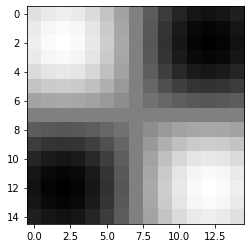

In [3]:
# making a one dimensional gaussian derivative filter according to the given sigma
def OneDimensionalGaussianDerivative(k=3,sigma=1):
    return [-x / (sqrt(2*pi) * sigma**3) * exp(-float(x)**2/(2*sigma**2)) for x in range(-int(k/2),int(k/2)+1)]

#The following are some example visuals of the 1D filter multiplied 
# with itself to create a 2D filter. Different sizes are shown.
print("Gaussian filer 3x3:")
temp_Gx_3x3 = np.array(OneDimensionalGaussianDerivative(3,1))
print(temp_Gx_3x3)
temp_G = temp_Gx_3x3 * temp_Gx_3x3.reshape(-1,1)
plt.figure()
plt.imshow(temp_G, cmap='gray')
plt.show()

print("Gaussian filer 5x5:")
temp_Gx_5x5 = np.array(OneDimensionalGaussianDerivative(5,2))
print(temp_Gx_5x5)
temp_G = temp_Gx_5x5 * temp_Gx_5x5.reshape(-1,1)
plt.imshow(temp_G, cmap='gray')
plt.show()

print("Gaussian filer 15x15:")
temp_Gx_15x15 = np.array(OneDimensionalGaussianDerivative(15,5))
print(temp_Gx_15x15)
temp_G = temp_Gx_15x15 * temp_Gx_15x15.reshape(-1,1)
plt.imshow(temp_G, cmap='gray')
plt.show()

In [4]:
#An implementation of a simple 1D convolution with 0's on the edges
def convolution1d(image, kernel):
  if (kernel.ndim == 1):
    n = kernel.size
    padding = n // 2
    if(image.ndim == 1):
      x = image.size
      new_image = np.zeros(x)
      for i in range(x - n + 1):
        new_image[i+ padding] = np.sum(image[i:i+n] * kernel)
  return new_image
  
#example of the convolution
# note that B only fits on index 2 and 3, so 1 and 4 won't be 
#calculated and left as a 0
A = np.array([10, 10, 11, 11])
B = np.array([-1, 0, 2])

convolution1d(A, B)

array([ 0., 12., 12.,  0.])

In [5]:
#An implementation of a simple 2D convolution with 0's on the edges
def convolution2d(image, kernel):
  h, w = kernel.shape
  if (h == w):
    padding = h // 2
    y, x = image.shape
    new_image = np.zeros((y,x))
    for i in range(y - h + 1):
      for j in range(x - h + 1):
        new_image[i+ padding][j + padding] = np.sum(image[i:i+h, j:j+h] * kernel)
  return new_image

#example of the convolution
# note that B only fits on the 4 central values, so 
#all the edges will be left as a 0
A = np.array(
    [[10, 10, 11, 11],
     [ 9, 10, 11, 11],
     [10, 10, 11, 11],
     [10, 10, 11, 11],])
B = np.array(
    [[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]])
     
convolution2d(A, B)

array([[0., 0., 0., 0.],
       [0., 6., 4., 0.],
       [0., 5., 4., 0.],
       [0., 0., 0., 0.]])

In [6]:
#for this, I had to decide how tick should I expect my edges to be
#Some of the example images that I chose have very fine edges that I wanted to detect
#So I decided to use a 3x3 window and do the supression there according to the 
#edge direction.
def NonMaxSuppression(img, angle):
  #figure out teh dimensions of the image
  h, w = img.shape
  #initialize all pixel in new image to none edges
  new_image = np.zeros((h,w), dtype=np.int32)
  angle = angle * 180. / np.pi #change to degrees

  #Loop thru entire image
  for i in range(1,h-1):
    for j in range(1,w-1):
      try:
        pixNext = 255 #set to max possible value
        pixPrev = 255 #set to max possible value
        
        #Figure out adjacent pixels in the direction of the gradient

        #Angles closest to the x axis
        if (-22.5 <= angle[i,j] < 22.5) or (-157.5 <= angle[i,j] < 157.5):
          pixNext = img[i, j+1] #Top
          pixPrev = img[i, j-1] #Bottom
        #Angles closest to the 45 degree line
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
          pixNext = img[i+1, j-1] #Bottom-Right
          pixPrev = img[i-1, j+1] #Top-Left
        #Angles closest to the y axis
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
          pixNext = img[i+1, j] #Right
          pixPrev = img[i-1, j] #Left
        #Angles closest to the 135 degree line
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
          pixNext = img[i-1, j-1] #Bottom-Left
          pixPrev = img[i+1, j+1] #Top-Right
        
        #If current pixel is > adjacent pixels then keep it
        if (img[i,j] >= pixNext) and (img[i,j] >= pixPrev):
          new_image[i,j] = img[i,j]
        else:
          new_image[i,j] = 0

      #cool trick I learned online
      except IndexError as e:
        pass

  return new_image

In [7]:
def HysteresisThresholding (img, treshHighPercentage, treshLowPercentage):
  # Get image dimensions
  h, w = img.shape
  new_img = np.zeros((h,w), dtype=np.int32)

  # Calcualte tresholds as a percentage of the max
  treshHigh = img.max() * treshHighPercentage;
  treshLow = treshHighPercentage * treshLowPercentage;

  #Activated pixel will be 255, but weak don't matter, they will go to 0 or 255
  strong = 255 #Max value
  weak = 100   #some value different than 255 and 0

  #First pass thru array, find all strong and weak pixels
  strong_i, strong_j = np.where(img >= treshHigh)
  weak_i, weak_j = np.where((img <= treshHigh) & (img >= treshLow))

  #Mark all strong and weak pixels. All others leave as 0's
  new_img[strong_i, strong_j] = strong
  new_img[weak_i, weak_j] = weak

  #Second pass, we can promote weak pixels to strong ones, or demote to 0's
  for i in range(1, h-1):
    for j in range(1, w-1):
      if (new_img[i,j] == weak):
        try:
          if (   (new_img[i  , j+1] == strong) # Up
              or (new_img[i  , j-1] == strong) # Down
              or (new_img[i+1, j  ] == strong) # Right
              or (new_img[i-1, j  ] == strong) # Left
              or (new_img[i+1, j+1] == strong) # Right-Up
              or (new_img[i+1, j-1] == strong) # Right-Down
              or (new_img[i-1, j+1] == strong) # Left-Up
              or (new_img[i-1, j-1] == strong) # Left-Down
              ): 
            new_img[i, j] = strong #promote to strong if nect to strong
          else:
            new_img[i, j] = 0 #demote to 0 for being a loner
        except IndexError as e:
          pass

  return new_img

In [8]:
def DoCannyEdgeDetection(title, image, kernelSize = 5, sigma = 2, treshHigh = 0.20, treshLow = 0.10):
  I = image
  # Apply Canny
  #edges = cv2.Canny(I, 100, 200, 3, L2gradient=True)

  width, heigth = I.shape

  Ix = []
  Iy = []
  Ixx = []
  Iyy = []

  #Create 1D Gaussian mask
  G = np.array(OneDimensionalGaussian(kernelSize, sigma))

  #Create 1D mask with the first derivative Gaussian
  Gx =  np.array(OneDimensionalGaussianDerivative(kernelSize, sigma))
  Gy = Gx.reshape(-1,1)

  #Blur the image to reduce noise along the x direction
  for i in range(width): #convolve along the rows
    Ix.append(convolution1d(I[i,:],G))
  Ix = np.array(Ix)

  #convolve with X derivatives of Gaussian
  for i in range(width):
    Ixx.append(convolution1d(Ix[i],Gx))
  Ixx = np.array(Ixx)

  #Blur the image to reduce noise along the y direction
  for j in range (heigth): #convolve along the columns
      Iy.append(convolution1d(I[:,j], G)) 
  Iy = np.array(np.transpose(Iy))

  #convolve with Y derivatives of Gaussian
  for j in range (heigth):
      Iyy.append(convolution1d(Iy[:,j], Gx)) #using Gx do the convolution, then fliping solution
  Iyy = np.array(np.transpose(Iyy))

  #compute the magnitude of the edge response
  Im = np.sqrt(np.square(Ixx) + np.square(Iyy))

  #Calculate edge direction at every pixel location
  Itheta = np.arctan2(Iy, Ix)

  #Do non max suppression
  ImaxSup = NonMaxSuppression(Im, Itheta)

  #do Hysteresis Thresholding and pass the high and low treshholds
  Ihyster = HysteresisThresholding(ImaxSup, treshHigh, treshLow)

  #Print image result
  plt.figure()
  plt.title(title)
  plt.imsave(title, I, cmap='gray', format='png')
  plt.imshow(I, cmap='gray')
  plt.show()

  plt.title(title + ': X component of the convolution with a Gaussian:')
  plt.imshow(Ix, cmap='gray')
  plt.show()

  plt.title(title + ': Y component of the convolution with a Gaussian:')
  plt.imshow(Iy, cmap='gray')
  plt.show()

  plt.title(title + ': X component of the convolution with the first derivative of a Gaussian:')
  plt.imshow(Ixx, cmap='gray')
  plt.show()

  plt.title(title + ': Y component of the convolution with the first derivative of a Gaussian:')
  plt.imshow(Iyy, cmap='gray')
  plt.show()

  plt.title(title + ': Magnitude image:')
  plt.imshow(Im, cmap='gray')
  plt.show()

  plt.title(title + ': Angle directions image:')
  plt.imshow(Itheta, cmap='gray') #TODO: add color for each direction
  plt.show()

  plt.title(title + ': Non Max Suppression image:')
  plt.imshow(ImaxSup, cmap='gray')
  plt.show()

  plt.title(title + ': After Hysteresis Thresholding, a.k.a. finished product:')
  plt.imshow(Ihyster, cmap='gray')
  plt.show()


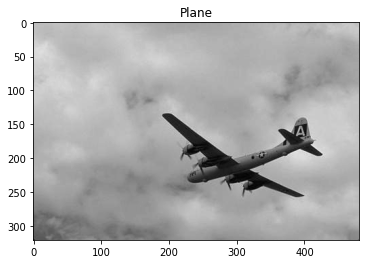

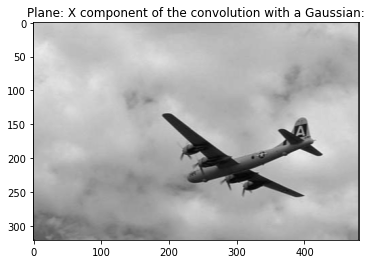

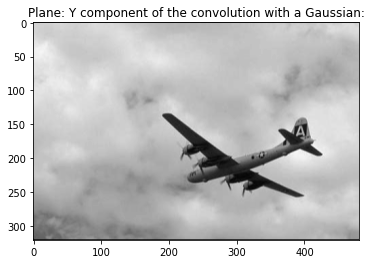

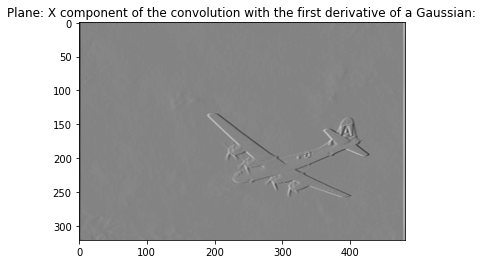

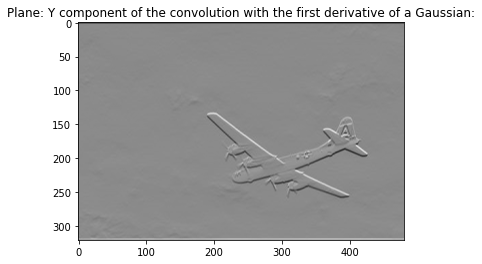

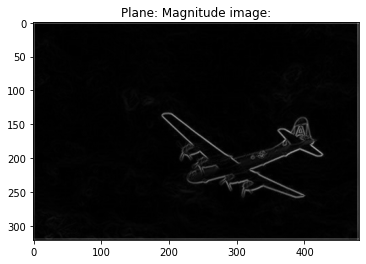

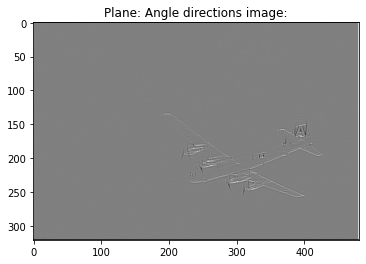

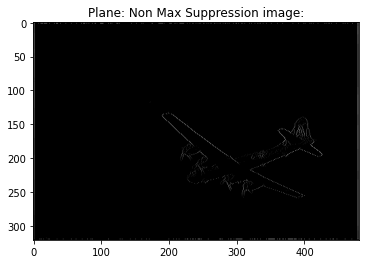

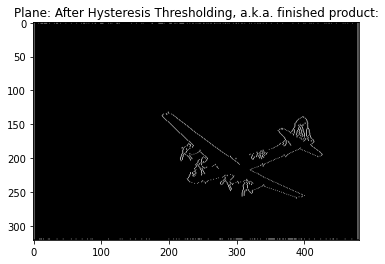

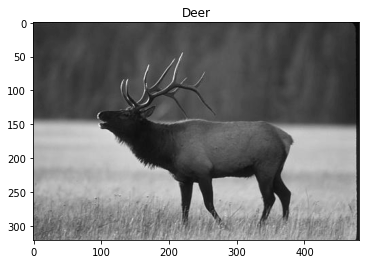

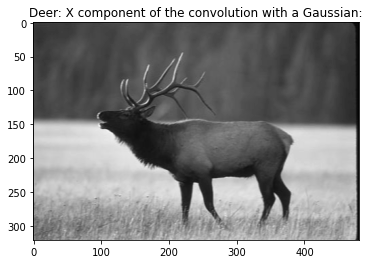

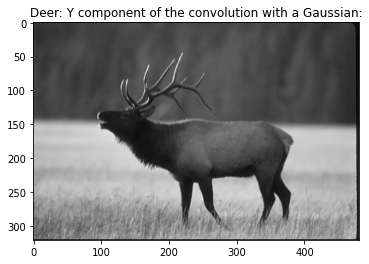

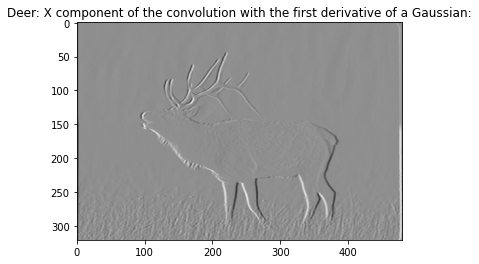

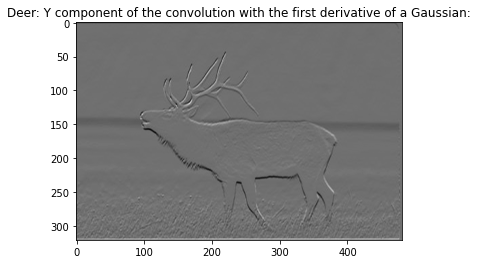

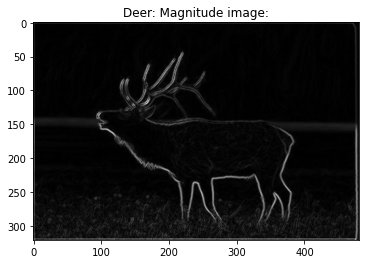

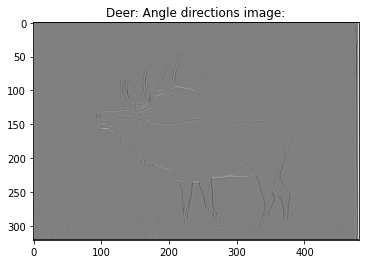

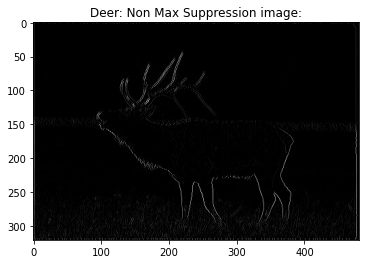

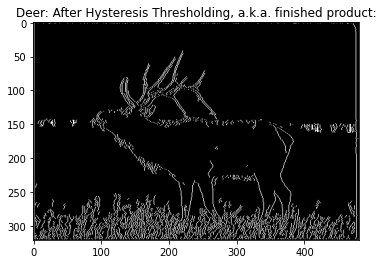

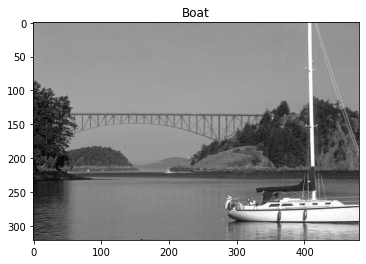

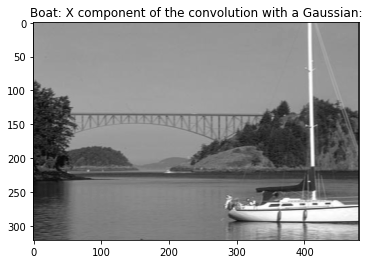

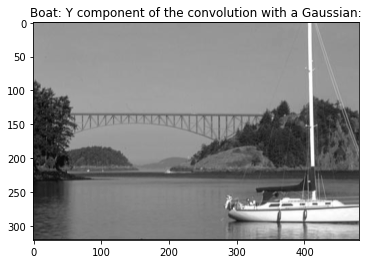

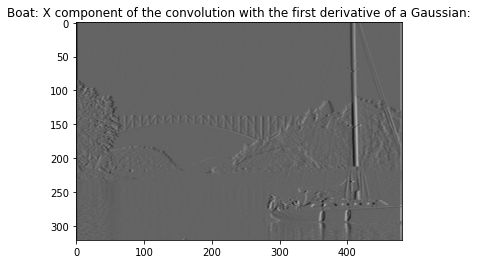

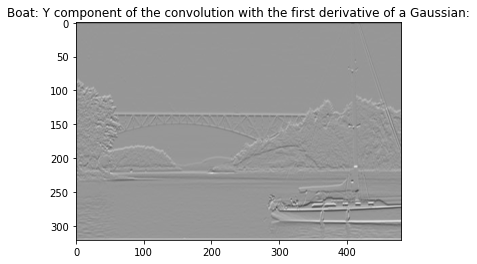

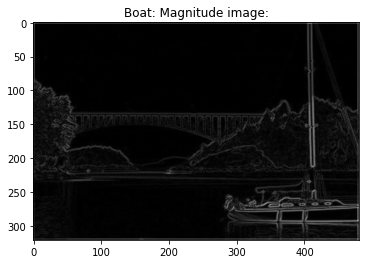

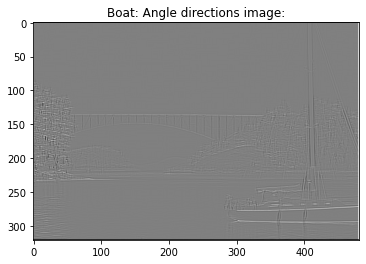

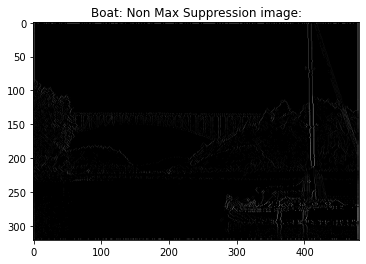

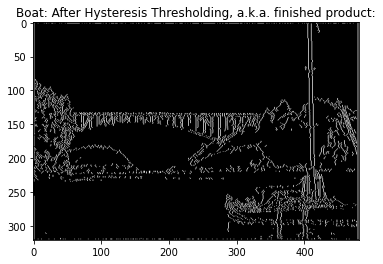

In [21]:
planeImg = np.array(Image.open(requests.get('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/gray/3096.jpg', stream=True).raw))
deerImg = np.array(Image.open(requests.get('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/gray/41004.jpg', stream=True).raw))
boatImg = np.array(Image.open(requests.get('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/gray/22090.jpg', stream=True).raw))

DoCannyEdgeDetection('Plane', planeImg, kernelSize = 3, sigma = 1.5, treshHigh = 0.10, treshLow = 0.05)
DoCannyEdgeDetection('Deer', deerImg, kernelSize = 3, sigma = 1, treshHigh = 0.10, treshLow = 0.05)
DoCannyEdgeDetection('Boat', boatImg, kernelSize = 3, sigma = 1.5, treshHigh = 0.10, treshLow = 0.05)